2022年香港中文大学的论文《Are Transformers Effective for Time Series Forecasting?》仅仅用最简单的Linear模型就结结实实的打脸了一众Transformer-based 模型，

最尴尬的是，在汇率预测上，一个简单的用昨天预测今天，或者上一个周期预测下一个周期的策略竟然比所有Transformer模型都表现得更好。这不禁让人怀疑，这些所谓的Transformer based究竟是在真的学习序列特征，还是只是在过拟合噪声，然后选择拟合的比较好的那些发表。

Transformer在NLP中的成功是基于其提取序列元素间语义相关性的能力。然而，时间序列数据本身通常缺乏语义，其核心在于建模连续点集中的时间关系，其中序列本身扮演着最关键的角色。

在自然语言中，即使完全打乱单词顺序，单纯的词义就可以反映相当多的原句的语义，Tramsformer模型再利用位置编码，建模词义之间的相对关系所带来的深层词义，来完成整个句子语义的处理。虽然位置编码可以保留一部分序列信息，但总归是有转换和丢失的。

面对时序数据，一个完全被打乱的序列，几乎丢掉了99%的信息，换言之时序数据的信息大部分都隐藏在相关关系中。在这种情况下，再去强行追求former系的并行性，用低效率的位置编码尝试保留序列信息，相当于是买椟还珠，本末倒置了。堆叠各种复杂的模型，并不一定就能取得更优的效果，更多只是基于发论文视角的为了创新而创新。

因此，在dive into deep learning 的各种 “former” 之前，需要先用传统的统计学工具建立一个科学而合理的基线模型，来区分哪些是真正有价值的，哪些只是花里胡哨的。



我们结合前述的所有框架，采用最简单的线性模型DLinear作为编码器，建立一个基线模型

在随机选取的数据区间和随机训练上，得到了平均11.65% (std 1.97%) 的超额预测准确率：即在做出预测的情况下（分类0 和分类2中），预测正确的概率超出预测完全错误的比例。

当然，这个模型还有一定的缺陷，比如做出预测的比例只有20%不到，大部分时间都会因为不能自信做出预测而选择放弃。

这个数字可以作为一个良好的模型评估基准，如果更为复杂的模型的准确率没有这样的效果，那就不得不思考当前的模型是否有效了

In [1]:
import os
os.chdir('d:/future/index_future_prediction/Index_Future_Prediction')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
from utils.random_split import RandomSplit, CallableDataset
from utils.back_test import BackTest
from utils.hybrid_loss import HybridLoss
from utils.hybrid_decoder import HybridDecoder
from utils.prediction_recorder import PredictionRecorder
from utils.train_animator import TrainAnimator
from utils.model_train import ModelTrain

In [4]:
feature = ['log_open','log_high','log_low','log_close','log_amount']
label = ['label_return','down_prob','middle_prob','up_prob']

In [ ]:
window_size = 40

In [6]:
from scipy.stats import norm
def process(data, pred_len):
    data.sort_values(by = 'trade_date', inplace = True)
    data['log_open'] = np.log(data['open'] / data['pre_close']) * 100 
    data['log_high'] = np.log(data['high'] / data['pre_close']) * 100 
    data['log_low'] = np.log(data['low'] / data['pre_close']) * 100 
    data['log_close'] = np.log(data['close'] / data['pre_close']) * 100
    data['log_amount'] = np.log(data['amount'] / data['amount'].shift(1)) * 10

    data['label_return'] = data['log_close'].rolling(window = pred_len).sum().shift(-pred_len)
    data['label_std'] = data['amount'].rolling(window = pred_len).mean().shift(-pred_len)/data['amount'].mean() * data['label_return'].std()

    threshold = (abs(data['label_return'].quantile(0.75)) + abs(data['label_return'].quantile(0.25)))/2

    def down_probability(row):
        return norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

    def middle_probability(row):
        return norm.cdf(threshold, loc = row['label_return'], scale=row['label_std']) - norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

    def up_probability(row):
        return 1 - norm.cdf(threshold, loc = row['label_return'], scale=row['label_std'])
    
    data['down_prob'] = data.apply(down_probability, axis = 1)
    data['middle_prob'] = data.apply(middle_probability, axis = 1)
    data['up_prob'] = data.apply(up_probability, axis = 1)
    data.dropna(inplace=True)
    print(f'{threshold:.2f}, {data['amount'].mean():.2f}, {data['label_return'].std():.2f}')
    return threshold, data['amount'].mean(), data['label_return'].std()

In [7]:
start_date = '20150101'
split_date = '20200101'
end_date = '20250101'

In [8]:
data = pro.index_daily(ts_code = '000016.SH', start_date = start_date, end_date = split_date)
process_info_ih = process(data, pred_len = 5)
feature_tensor = torch.tensor(data[feature].values, dtype = torch.float32, device = 'cuda:0')
feature_tensor = feature_tensor.unfold(dimension = 0, size = window_size, step = 1).transpose(1,2)

label_tensor = torch.tensor(data[label].values, dtype = torch.float32, device = 'cuda:0')
label_tensor = label_tensor[window_size-1:]

train_set = CallableDataset(feature_tensor, label_tensor)

1.66, 58660491.51, 3.41


In [9]:
data

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,...,log_open,log_high,log_low,log_close,log_amount,label_return,label_std,down_prob,middle_prob,up_prob
1217,000016.SH,20150106,2629.4020,2616.2910,2691.4890,2591.8280,2649.6390,-20.2370,-0.7638,173439993.0,...,-1.266574,1.567117,-2.205999,-0.766696,-0.406916,-3.939601,9.607329,0.593856,0.126079,0.280065
1216,000016.SH,20150107,2635.2310,2608.8770,2668.8390,2598.8900,2629.4020,5.8290,0.2217,128317720.0,...,-0.783658,1.488710,-1.167201,0.221440,-2.124090,-3.908100,8.862864,0.600202,0.134808,0.264990
1215,000016.SH,20150108,2558.1070,2647.8170,2656.7520,2551.8160,2635.2310,-77.1240,-2.9267,118367915.0,...,0.476468,0.813348,-3.216558,-2.970331,-1.272856,2.881457,8.911352,0.305232,0.140173,0.554596
1214,000016.SH,20150109,2569.0190,2554.2860,2692.6070,2540.3420,2558.1070,10.9120,0.4266,156209510.0,...,-0.149480,5.124234,-0.696881,0.425658,2.952210,3.217978,8.575464,0.284811,0.143019,0.572170
1213,000016.SH,20150112,2543.8520,2565.7370,2596.2680,2499.8690,2569.0190,-25.1670,-0.9796,119183586.0,...,-0.127835,1.055092,-2.728578,-0.984465,-2.279787,-5.396932,8.500261,0.669977,0.126747,0.203276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,000016.SH,20191218,3025.7847,3031.8873,3041.8336,3020.9464,3033.1423,-7.3576,-0.2426,32492619.0,...,-0.041385,0.286135,-0.402899,-0.242868,-3.554576,-1.323456,2.311785,0.442453,0.458973,0.098574
8,000016.SH,20191219,3017.7128,3027.6745,3029.7019,3009.8707,3025.7847,-8.0719,-0.2668,26929092.0,...,0.062437,0.129377,-0.527334,-0.267127,-2.484208,-0.201571,2.266277,0.260211,0.533847,0.205942
7,000016.SH,20191220,3012.6257,3022.1196,3033.5621,3009.3843,3017.7128,-5.0871,-0.1686,25092228.0,...,0.145925,0.523835,-0.276369,-0.168717,0.120566,0.170901,2.436403,0.226418,0.502786,0.270796
6,000016.SH,20191223,2984.2426,3015.2940,3028.5599,2982.0214,3012.6257,-28.3831,-0.9421,27450023.0,...,0.088531,0.527520,-1.021063,-0.946604,0.808880,2.596723,2.794133,0.063908,0.304554,0.631537


In [12]:
train_set.all()[0].shape

torch.Size([1184, 30, 5])

In [14]:
from scipy.stats import norm
def process_test(data, pred_len, threshold, amount_mean, return_std):
    data.sort_values(by = 'trade_date', inplace = True)
    data['log_open'] = np.log(data['open'] / data['pre_close']) * 100 
    data['log_high'] = np.log(data['high'] / data['pre_close']) * 100 
    data['log_low'] = np.log(data['low'] / data['pre_close']) * 100 
    data['log_close'] = np.log(data['close'] / data['pre_close']) * 100
    data['log_amount'] = np.log(data['amount'] / data['amount'].shift(1)) * 10

    data['label_return'] = data['log_close'].rolling(window = pred_len).sum().shift(-pred_len)
    data['label_std'] = data['amount'].rolling(window = pred_len).mean().shift(-pred_len) / amount_mean * return_std

    def down_probability(row):
        return norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

    def middle_probability(row):
        return norm.cdf(threshold, loc = row['label_return'], scale=row['label_std']) - norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

    def up_probability(row):
        return 1 - norm.cdf(threshold, loc = row['label_return'], scale=row['label_std'])
    
    data['down_prob'] = data.apply(down_probability, axis = 1)
    data['middle_prob'] = data.apply(middle_probability, axis = 1)
    data['up_prob'] = data.apply(up_probability, axis = 1)
    data.dropna(inplace=True)

    threshold_test = (abs(data['label_return'].quantile(0.75)) + abs(data['label_return'].quantile(0.25)))/2

    print(f'train: {threshold:.2f}, {amount_mean:.2f}, {return_std:.2f}')
    print(f'test :{threshold_test:.2f}, {data['amount'].mean():.2f}, {data['label_return'].std():.2f}')

In [15]:
data = pro.index_daily(ts_code = '000016.SH', start_date = split_date, end_date = end_date)
process_test(data, 5, *process_info_ih)
feature_tensor = torch.tensor(data[feature].values, dtype = torch.float32, device = 'cuda:0')
feature_tensor = feature_tensor.unfold(dimension = 0, size = window_size, step = 1).transpose(1,2)

label_tensor = torch.tensor(data[label].values, dtype = torch.float32, device = 'cuda:0')
label_tensor = label_tensor[window_size-1:]

validation_set = CallableDataset(feature_tensor, label_tensor)

train: 1.66, 58660491.51, 3.41
test :1.52, 71332753.26, 2.79


In [18]:
test_set = validation_set

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, seq_len, pred_len, individual, enc_in, kernel_size):
        super(DLinear, self).__init__()

        self.seq_len = seq_len # 输入序列的长度
        self.pred_len = pred_len # 预测序列的长度

        # Decompsition Kernel Size
        self.kernel_size = kernel_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual # 是否为每个feature应用不同的参数
        self.channels = enc_in # feature的个数 例如OHLCV数据为5

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
    def forward(self, x):
        # x: [Batch, Input length, Channel]

        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]


In [ ]:
class DLinearOutput(nn.Module):
    """循环神经网络模型"""
    def __init__(self, seq_len, pred_len, individual, enc_in, kernel_size, init_prob, dropout, **kwargs):
        super(DLinearOutput, self).__init__(**kwargs)
        self.device = 'cuda:0'

        self.process = nn.Sequential(
            DLinear(seq_len = seq_len, pred_len =  pred_len, individual = individual, enc_in = enc_in, kernel_size = kernel_size),
            nn.Sequential(nn.Flatten(start_dim = 1), nn.Dropout(dropout))
            )

        self.output = HybridDecoder(pred_len * enc_in, init_prob = init_prob)

    def forward(self, x):
        x = self.process(x)
        return self.output(x)

In [21]:
recorder = PredictionRecorder(is_logits = True)
animator = TrainAnimator(figsize=(12,6))

Animator data has been reset.


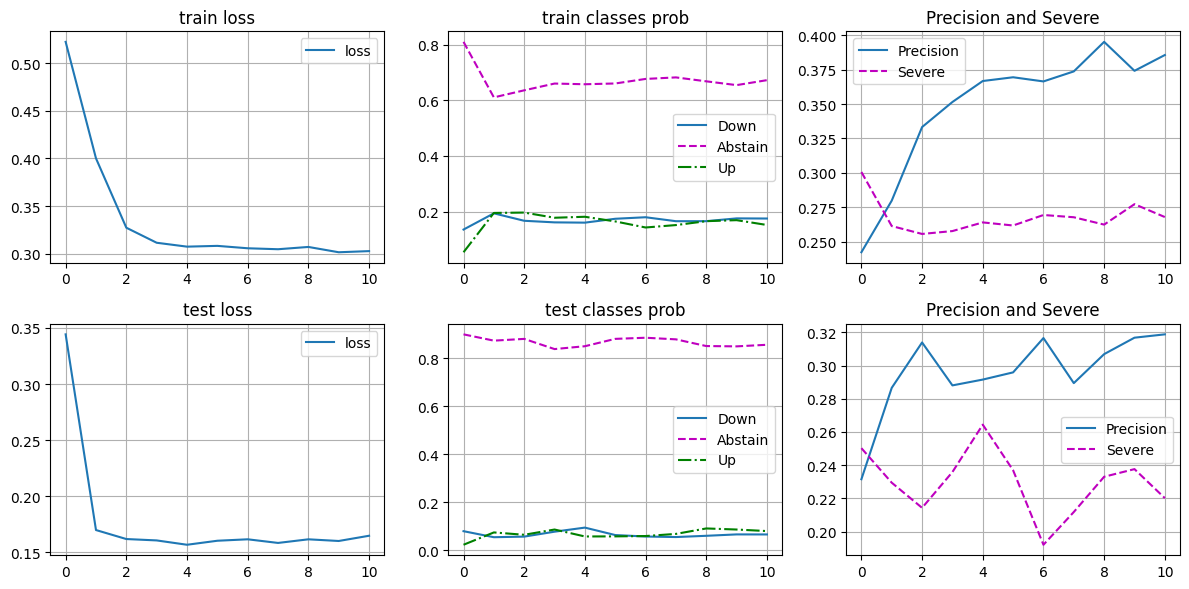

100%|██████████| 100/100 [00:00<00:00, 296.75it/s]


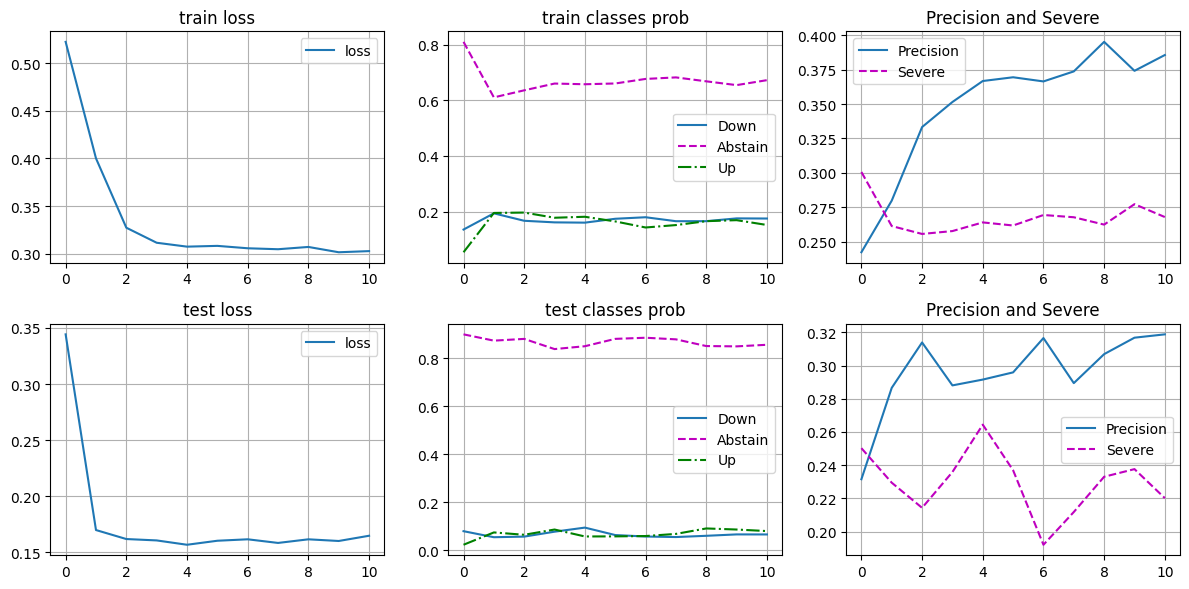

In [ ]:
gap = []
for i in range(10):
    
    animator.reset()
    loss_fn = HybridLoss(alpha = 1e-3, delta = 1)
    model = DLinearOutput(seq_len = 40, pred_len = 5, individual = True, enc_in = 5, kernel_size = 21, init_prob = [0.0, 1, 0.0], dropout = 0.5).to('cuda:0')
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-1)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
    train = ModelTrain(model = model,
                       batch_size = 100,
                   train_set = train_set,
                   validation_set=validation_set,
                   test_set=test_set,
                   loss_fn = loss_fn,
                   optimizer = optimizer,
                   scheduler=scheduler,
                   recorder=recorder,
                   graph=animator,
                   threshold = 1.8,
                   )
    precision, severe = train.epoch_train(epochs = 10, round = 100, early_stop = 100)

    gap.append(precision - severe)


In [24]:
print(f'超额正确率均值  ：{np.mean(gap):.2%}')
print(f'超额正确率标准差：{np.std(gap):.2%}')

超额正确率均值  ：11.65%
超额正确率标准差：1.97%


In [25]:
# torch.save(model.state_dict(), 'params/baseline.params')